In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pulp
import sys
import os
import importlib.util
import importlib
import gurobipy as gp

# モジュールを強制的に再ロード（古いキャッシュをクリア）
if 'code' in sys.modules:
    del sys.modules['code']
# サブモジュールも削除
for module_name in list(sys.modules.keys()):
    if module_name.startswith('code.'):
        del sys.modules[module_name]

current_dir = os.getcwd()
spec = importlib.util.spec_from_file_location("code", os.path.join(current_dir, "code", "__init__.py"))
code_module = importlib.util.module_from_spec(spec)
sys.modules["code"] = code_module
spec.loader.exec_module(code_module)

# サブモジュールも再ロード
importlib.reload(code_module)

make_tensor_grid_3d = code_module.make_tensor_grid_3d
product_beta_density = code_module.product_beta_density
solve_mechanism_2agents = code_module.solve_mechanism_2agents
solve_mechanism_2agents_iterative = code_module.solve_mechanism_2agents_iterative
plot_polyhedral_regions = code_module.plot_polyhedral_regions
save_results_2agents = code_module.save_results_2agents
load_results_2agents = code_module.load_results_2agents

print("モジュールを再ロードしました")


モジュールを再ロードしました


In [14]:
home_license = os.path.expanduser('~/gurobi.lic')
os.environ['GRB_LICENSE_FILE'] = home_license

SOLVER = pulp.GUROBI(msg=True)

In [15]:
# ケース1: 2人2財1シナジー
# 各参加者のグリッドサイズ（3次元すべて同じサイズ）
N1 = 6
N2 = 6

# 各参加者のBeta分布パラメータ
# [財a, 財b, シナジーα]
BETA_PARAMS_1 = [
    (1.0, 1.0),  # 参加者1の財a
    (1.0, 1.0),  # 参加者1の財b
    (1.0, 1.0),  # 参加者1のシナジーα
]

BETA_PARAMS_2 = [
    (1.0, 1.0),  # 参加者2の財a
    (1.0, 1.0),  # 参加者2の財b
    (1.0, 1.0),  # 参加者2のシナジーα
]


In [16]:
# 各参加者のグリッド点と重みを生成
points1, weights1 = make_tensor_grid_3d(N1, N1, N1, BETA_PARAMS_1)
points2, weights2 = make_tensor_grid_3d(N2, N2, N2, BETA_PARAMS_2)

print(f"#types agent1 = {len(points1)}")
print(f"#types agent2 = {len(points2)}")
print(f"Total type combinations = {len(points1) * len(points2)}")
print("ex. first point agent1, weight =", points1[0], weights1[0])
print("ex. first point agent2, weight =", points2[0], weights2[0])


#types agent1 = 216
#types agent2 = 216
Total type combinations = 46656
ex. first point agent1, weight = (0.08333333333333333, 0.08333333333333333, 0.08333333333333333) 0.004629629629629629
ex. first point agent2, weight = (0.08333333333333333, 0.08333333333333333, 0.08333333333333333) 0.004629629629629629


In [ ]:
# 反復的制約追加アルゴリズムで最適オークション機構を求解
status, obj_val, u1_sol, u2_sol, p1_sol, p2_sol, n_iter = solve_mechanism_2agents_iterative(
    points1, weights1, (N1, N1, N1),
    points2, weights2, (N2, N2, N2),
    solver=SOLVER
)

print("\nLP status:", status)
print("Optimal revenue:", obj_val)
print(f"Number of iterations: {n_iter}")

# 結果を保存
filepath_2agents = save_results_2agents(
    points1, weights1, points2, weights2,
    u1_sol, u2_sol, p1_sol, p2_sol,
    obj_val, status,
    grid_sizes1=(N1, N1, N1),
    grid_sizes2=(N2, N2, N2),
    n_iter=n_iter,
    filename="results_2agents.npz"
)


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2749041 - for non-commercial use only - registered to ko___@u.northwestern.edu
Optimize a model with 1399680 rows, 466560 columns and 4245696 nonzeros (Max)
Model fingerprint: 0x0e5bb5b6
Model has 373248 linear objective coefficients
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [2e-06, 2e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 469584 rows and 93312 columns
Presolve time: 3.09s
Presolved: 930096 rows, 373248 columns, 2861136 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 5.22s
Presolved: 373248 rows, 1210032 columns, 3141072 nonzeros

Elapsed ordering time = 6s
Elapsed ordering time = 9s
Elapsed ordering time = 10s
Elapsed ordering time =

Agent 2 type for (0,0,0) case: (0.1, 0.1, 0.1) (index 0)
Agent 2 type for (1,1,1) case: (0.9, 0.9, 0.9) (index 124)


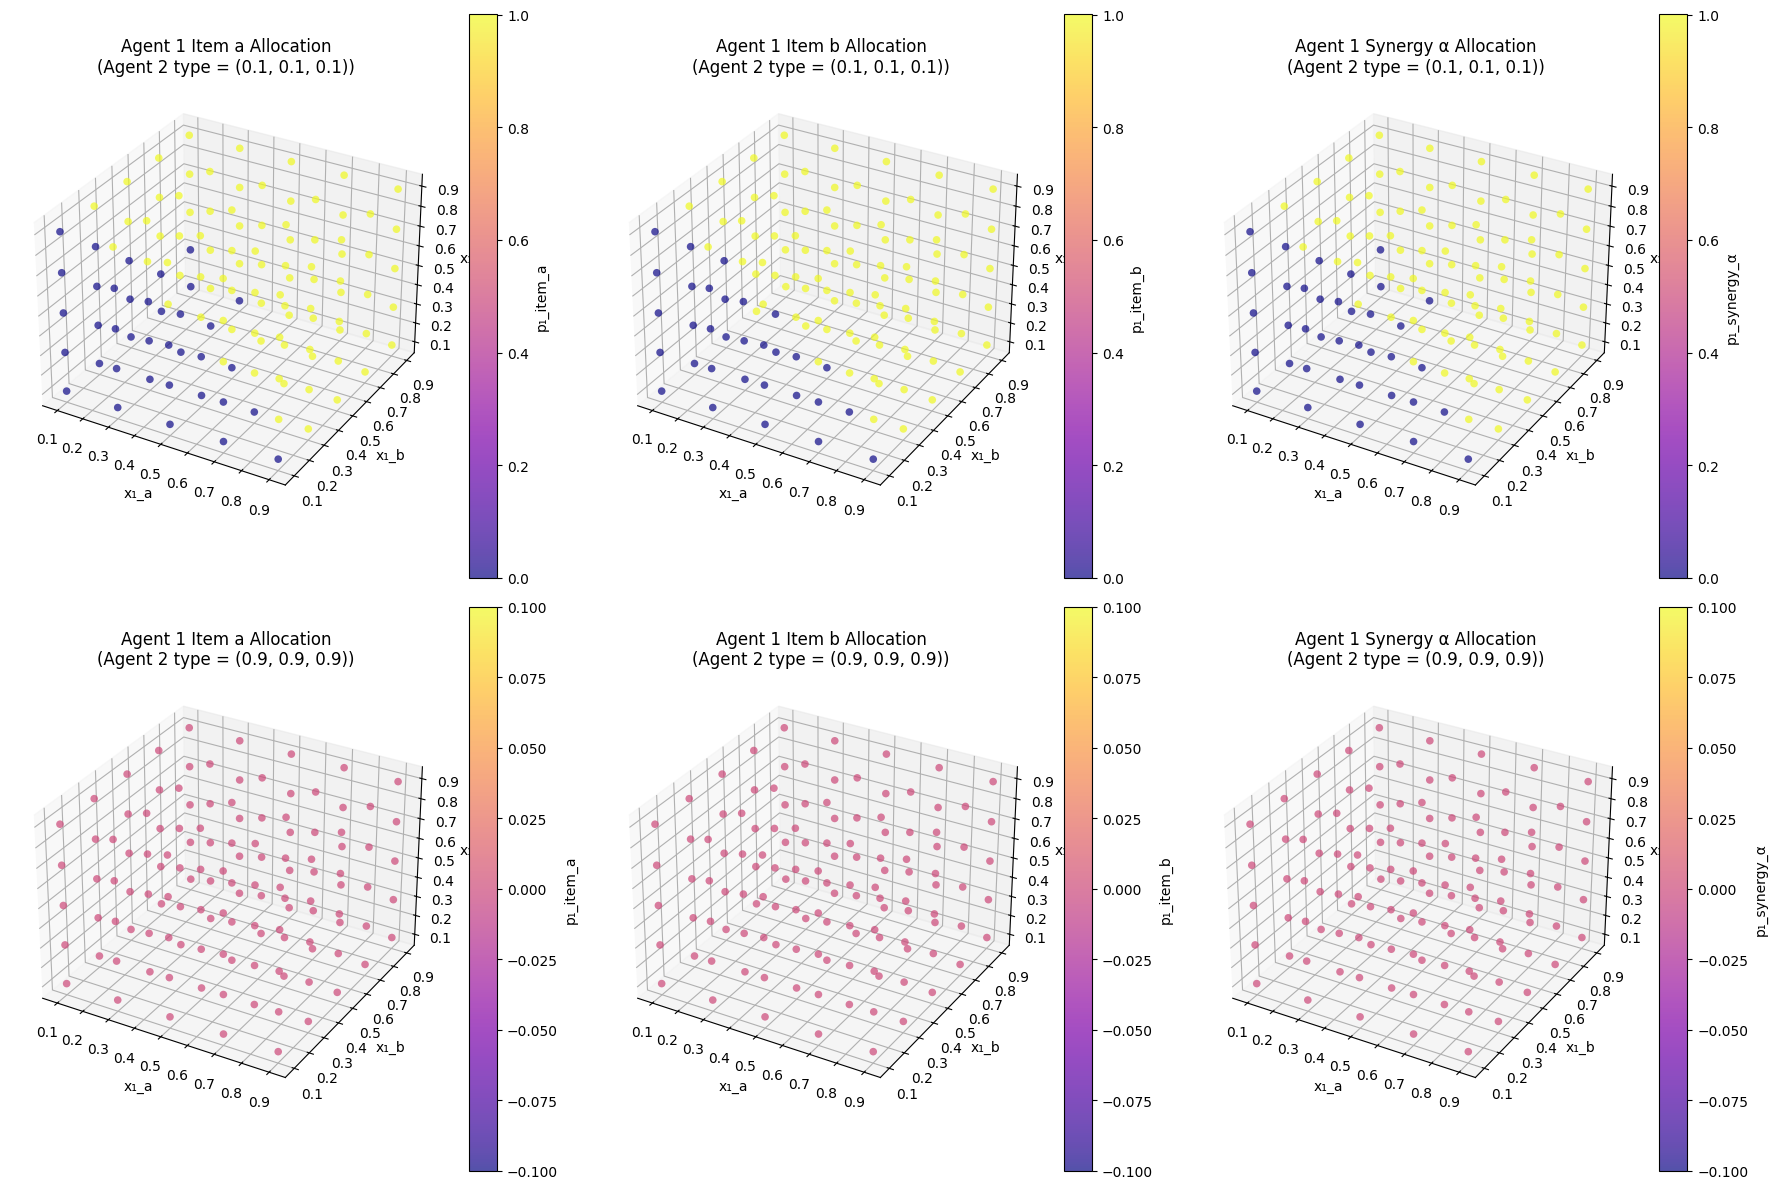


可視化完了:
  - 参加者1の効用の平均: 0.1702
  - 参加者2の効用の平均: 0.1588
  - 参加者1の各財の割り当て確率の平均:
    Item a: 0.4701
    Item b: 0.4842
    Synergy α: 0.4701
  - 参加者2の各財の割り当て確率の平均:
    Item a: 0.4467
    Item b: 0.4468
    Synergy α: 0.4313


In [ ]:
# 可視化用のデータ準備
# 計算結果から直接可視化
points1_arr = np.array(points1)
points2_arr = np.array(points2)
p1_arr = np.array(p1_sol)
p2_arr = np.array(p2_sol)

# または、保存されたデータから読み込む
# data = load_results_2agents("data/results_2agents.npz")
# points1_arr = data['points1']
# points2_arr = data['points2']
# p1_arr = data['p1_sol']
# p2_arr = data['p2_sol']

# 参加者2が(0,0,0)に最も近い型を見つける
# グリッド点は (i+0.5)/N の形式なので、最初の点が最小値
j2_min = 0
points2_min = points2[j2_min]

# 参加者2が(1,1,1)に最も近い型を見つける
# 最後の点が最大値
j2_max = len(points2) - 1
points2_max = points2[j2_max]

print(f"Agent 2 type for (0,0,0) case: {points2_min} (index {j2_min})")
print(f"Agent 2 type for (1,1,1) case: {points2_max} (index {j2_max})")

# 参加者1の配分確率（参加者2の型を固定）
# p1_arrの形状は (3, J1, J2)
p1_min = p1_arr[:, :, j2_min]  # 参加者2が(0,0,0)の時: (3, J1)
p1_max = p1_arr[:, :, j2_max]  # 参加者2が(1,1,1)の時: (3, J1)

# 6つの可視化を作成
fig = plt.figure(figsize=(18, 12))

# 参加者2が(0,0,0)の時: 参加者1の財a, 財b, シナジーαの配分確率
for i, (label, idx) in enumerate([('Item a', 0), ('Item b', 1), ('Synergy α', 2)], 1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    scatter = ax.scatter(
        points1_arr[:, 0], points1_arr[:, 1], points1_arr[:, 2],
        c=p1_min[idx], s=30, cmap='plasma', alpha=0.7, edgecolors='none'
    )
    ax.set_xlabel('x₁_a')
    ax.set_ylabel('x₁_b')
    ax.set_zlabel('x₁_α')
    ax.set_title(f'Agent 1 {label} Allocation\n(Agent 2 type = {points2_min})')
    plt.colorbar(scatter, ax=ax, label=f'p₁_{label.lower().replace(" ", "_")}')

# 参加者2が(1,1,1)の時: 参加者1の財a, 財b, シナジーαの配分確率
for i, (label, idx) in enumerate([('Item a', 0), ('Item b', 1), ('Synergy α', 2)], 4):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    scatter = ax.scatter(
        points1_arr[:, 0], points1_arr[:, 1], points1_arr[:, 2],
        c=p1_max[idx], s=30, cmap='plasma', alpha=0.7, edgecolors='none'
    )
    ax.set_xlabel('x₁_a')
    ax.set_ylabel('x₁_b')
    ax.set_zlabel('x₁_α')
    ax.set_title(f'Agent 1 {label} Allocation\n(Agent 2 type = {points2_max})')
    plt.colorbar(scatter, ax=ax, label=f'p₁_{label.lower().replace(" ", "_")}')

plt.tight_layout()
plt.show()

print(f"\n可視化完了:")
print(f"  - 参加者1の効用の平均: {np.mean(u1_sol):.4f}")
print(f"  - 参加者2の効用の平均: {np.mean(u2_sol):.4f}")
print(f"  - 参加者1の各財の割り当て確率の平均:")
for i, label in enumerate(['Item a', 'Item b', 'Synergy α']):
    print(f"    {label}: {np.mean(p1_arr[i]):.4f}")
print(f"  - 参加者2の各財の割り当て確率の平均:")
for i, label in enumerate(['Item a', 'Item b', 'Synergy α']):
    print(f"    {label}: {np.mean(p2_arr[i]):.4f}")


Agent 2 type = (0,0,0) case:


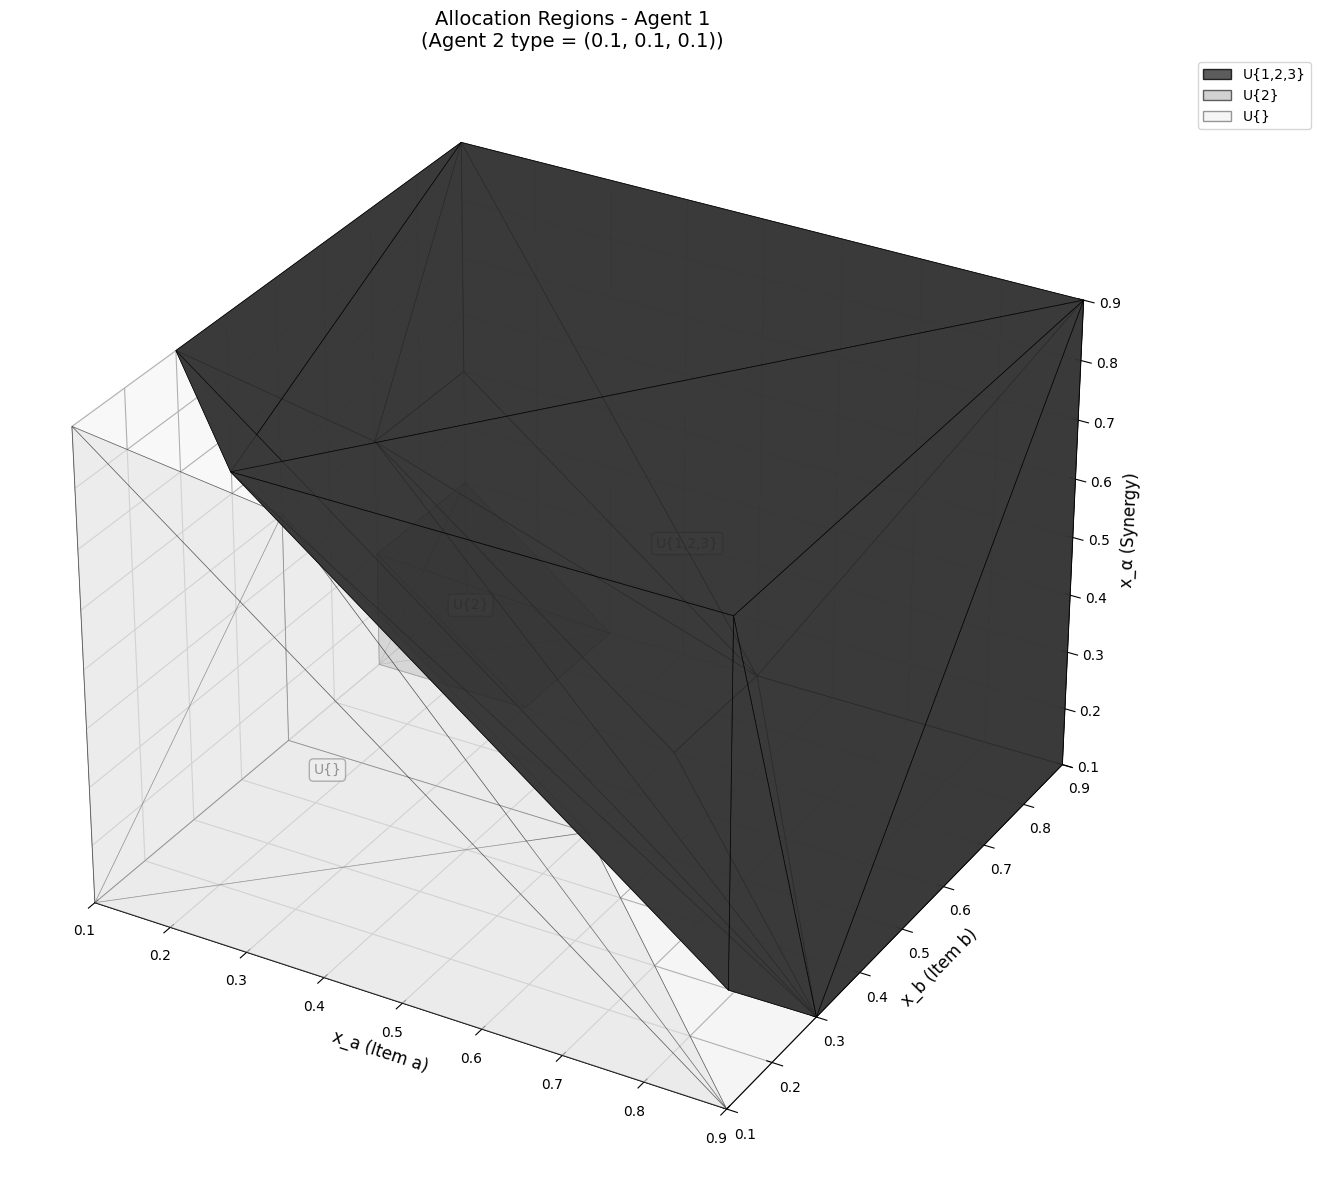

領域の統計:
  U{1,2,3}: 88 点
  U{2}: 6 点
  U{}: 31 点

Agent 2 type = (1,1,1) case:


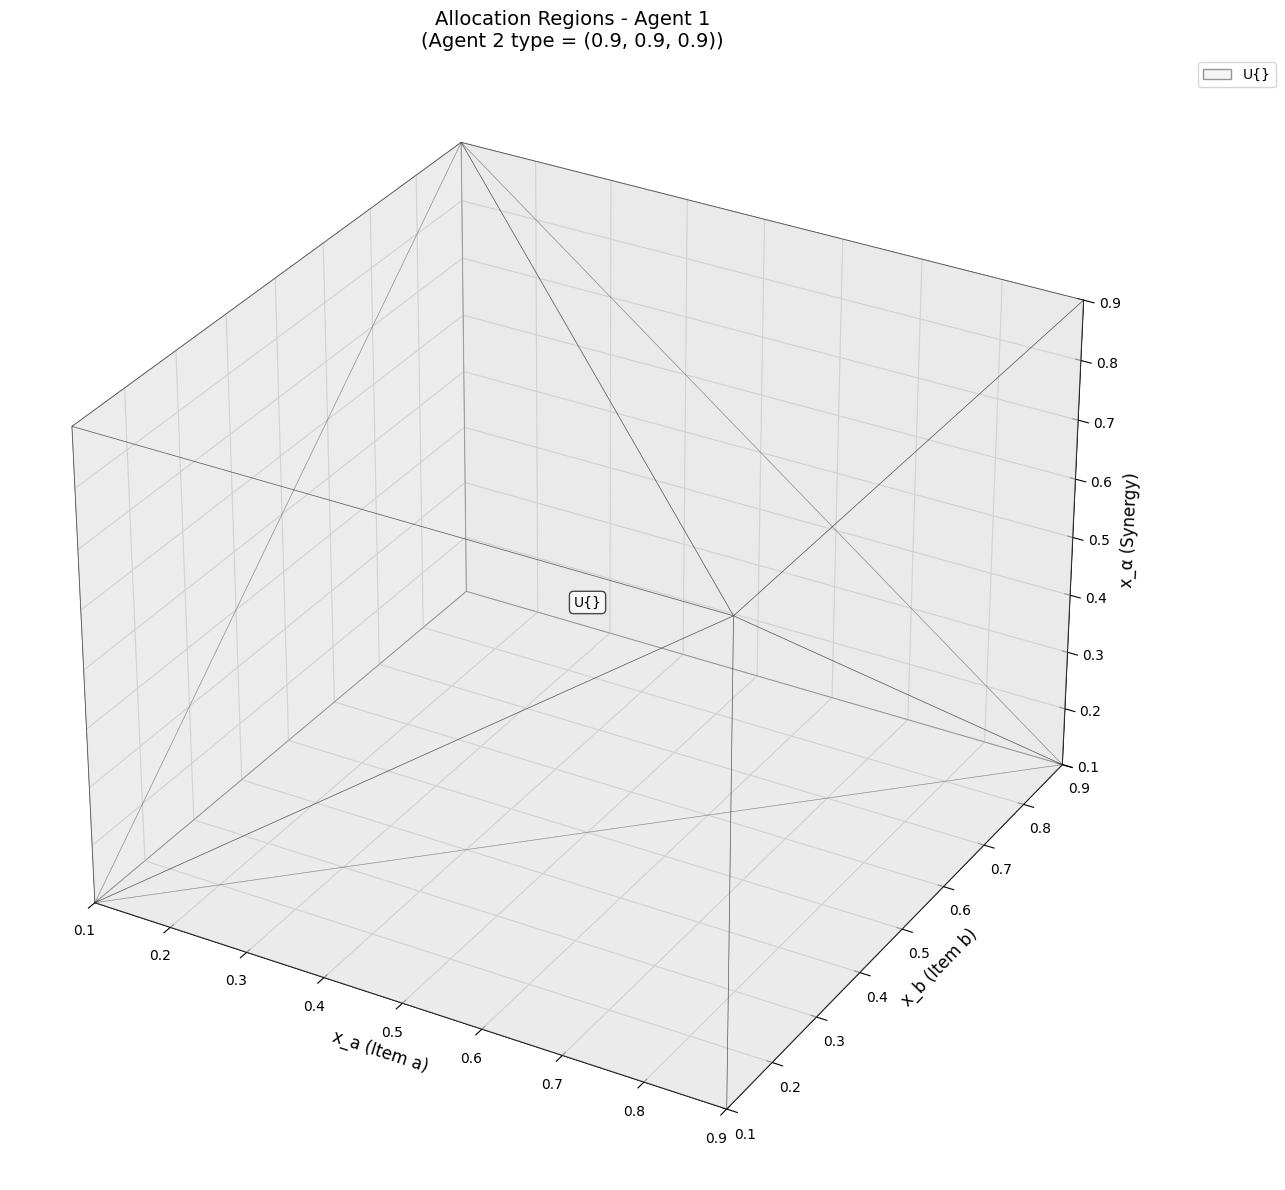

領域の統計:
  U{}: 125 点


In [ ]:
# plot_polyhedral_regionsを使った可視化
# 参加者2が(0,0,0)と(1,1,1)の2ケースで、参加者1の配分領域を可視化

# 計算結果から直接可視化
# 参加者2が(0,0,0)に最も近い型
j2_min = 0
points2_min = points2[j2_min]

# 参加者2が(1,1,1)に最も近い型
j2_max = len(points2) - 1
points2_max = points2[j2_max]

# 参加者1の配分確率（参加者2の型を固定）
# p1_arrの形状は (3, J1, J2)
p1_min = p1_arr[:, :, j2_min]  # 参加者2が(0,0,0)の時: (3, J1)
p1_max = p1_arr[:, :, j2_max]  # 参加者2が(1,1,1)の時: (3, J1)

# または、保存されたデータから読み込んで可視化
# data = load_results_2agents("data/results_2agents.npz")
# points1_arr = data['points1']
# points2_arr = data['points2']
# p1_arr = data['p1_sol']
# j2_min = 0
# j2_max = len(points2_arr) - 1
# p1_min = p1_arr[:, :, j2_min]
# p1_max = p1_arr[:, :, j2_max]

# 参加者2が(0,0,0)の時の参加者1の配分領域可視化
print("Agent 2 type = (0,0,0) case:")
region_groups1_min = plot_polyhedral_regions(
    points1_arr, p1_min, p1_min[2],
    title=f"Allocation Regions - Agent 1\n(Agent 2 type = {points2_min})"
)

# 参加者2が(1,1,1)の時の参加者1の配分領域可視化
print("\nAgent 2 type = (1,1,1) case:")
region_groups1_max = plot_polyhedral_regions(
    points1_arr, p1_max, p1_max[2],
    title=f"Allocation Regions - Agent 1\n(Agent 2 type = {points2_max})"
)
